## Test utility class to generate features from multiple files

In [1]:
import sys
sys.path.append('/home/zhay/DEEP/python/')
sys.path.append('/home/zhay/DEEP/python/lib/')
sys.path.append('/home/zhay/DEEP/python/machineLearning/')

import scipy as sp
import pandas as pd
import numpy as np
import pickle
from time import time
import matplotlib.pyplot as plt
from scipy import signal
from StickSlipDetector import StickSlipDetector
from keras.models import Model,load_model, save_model
from keras.layers import Input,LSTM,Dense,Conv1D,MaxPooling1D,Dropout,BatchNormalization,Flatten
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.layers import merge,concatenate
import keras
from keras_utility import precision, recall, binary_xentropy, fmeasure, augmentData,cut_to_batch
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.utils import np_utils
from keras.optimizers import Adam
from IPython.display import SVG

import deep_util
import modeldef
from imp import reload
reload(deep_util)
reload(modeldef)
%matplotlib notebook

Using TensorFlow backend.


### Load data from multiple wells and merge 

### Load data with feature generator

### Set processing parameters

In [2]:
trainingFileList=['/home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_30s_8channel_RR30_noNorm.p',
#               '/home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_30s_8channel_RR31.p',
              '/home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_30s_8channel_RR32_noNorm.p',
              '/home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_30s_8channel_RR34_noNorm.p',
              '/home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_30s_8channel_RR35_noNorm.p'
             ]

testFileList=['/home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_30s_8channel_RR31_noNorm.p',
#               '/home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_30s_8channel_RR31.p',
#               '/home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_60s_6channel_RR32.p',
#               '/home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_60s_6channel_RR34.p',
#               '/home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_60s_6channel_RR35.p'
             ]
# parameters to generate spectrogram
nfft=1024
nfftOverlap=nfft*0.9

# sampling rate of data
fs=100
dt=1/fs

# maximum frequency to look at 
freqMax=20

batchSize=32
conditionList=[['01_Global-Generic_Surface-copRigState',0,100],['01_Global-Generic_Surface-SRPM',50,1000],
#                ['01_Global-Generic_Surface-BIT_DEPTH', 8500/3.28,12500/3.28]
              ]
fg = deep_util.FeatureGenerator()
fg.setParam(nfft=nfft,nfftOverlap=nfftOverlap,freqMax=freqMax,batchSize=batchSize,conditionList=conditionList)

X_train,Y_train,auxDataDict_train=fg.GenerateFeatures(trainingFileList,conditionList,ytype='mean',cutToBatch=True)
X_test,Y_test,auxDataDict_test=fg.GenerateFeatures(testFileList,conditionList,ytype='mean',cutToBatch=True)

Reading file /home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_30s_8channel_RR30_noNorm.p
reading 19532.000000 samples
Reading file /home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_30s_8channel_RR32_noNorm.p
reading 13200.000000 samples
Reading file /home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_30s_8channel_RR34_noNorm.p
reading 16624.000000 samples
Reading file /home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_30s_8channel_RR35_noNorm.p
reading 22254.000000 samples
Size of merged data X is: 
number of samples
71610
Shape of X (nsample,nt,nchannel):
(71610, 3000, 8)
 0 percent finished
10 percent finished
20 percent finished
30 percent finished
40 percent finished
50 percent finished
60 percent finished
70 percent finished
80 percent finished
90 percent finished
Reading file /home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_30s_8channel_RR31_noNorm.p
reading 26738.000000 samples
Size of merged data X i

In [3]:
auxDataDict_train

{'01_Global-Generic_Surface-BIT_DEPTH': array([ 1525.2034,  1525.851 ,  1526.4298, ...,  5280.0915,  5280.3628,
         5280.5076]),
 '01_Global-Generic_Surface-SRPM': array([ 59.982464,  59.81101 ,  60.096775, ...,  79.92899 ,  80.07188 ,
         79.986145]),
 '01_Global-Generic_Surface-SWOB': array([ 150821.26,  149696.3 ,  153279.44, ...,  191442.6 ,  201339.08,
         193027.92]),
 '01_Global-Generic_Surface-copROP': array([ 66.381782,  73.13737 ,  75.72695 , ...,  22.933152,  31.857696,
         19.56816 ]),
 '01_Global-Generic_Surface-copRigState': array([ 0.,  0.,  0., ...,  0.,  0.,  0.])}

In [4]:
Xt_train,Xs_train=X_train
Yt_train,Ys_train=Y_train

Xt_test,Xs_test=X_test
Yt_test,Ys_test=Y_test
print('training data shape')
print(Xt_train.shape)
print(Xs_train.shape)

print('test data shape')
print(Xt_test.shape)
print(Xs_test.shape)

# scaler.fit?

training data shape
(21920, 3000, 8, 1)
(21920, 20, 205, 8)
test data shape
(6560, 3000, 8, 1)
(6560, 20, 205, 8)


### Normalization and standardization


In [5]:
from deep_util import FeatureScaler4D
scaler_time = FeatureScaler4D(channelDim=2)
scaler_time.fit(Xt_train)
Xt_train_norm=scaler_time.transform(Xt_train)
# Xt_train_inverse = scaler_time.inverse_transform(Xt_train_norm)

scaler_spec = FeatureScaler4D(channelDim=3)
scaler_spec.fit(Xs_train)
Xs_train_norm=scaler_spec.transform(Xs_train)
# Xs_train_inverse = scaler_spec.inverse_transform(Xs_train_norm)


# scale validation data
Xt_test_norm=scaler_time.transform(Xt_test)
Xs_test_norm=scaler_spec.transform(Xs_test)

Xnorm_train = [Xt_train_norm,Xs_train_norm]
Xnorm_test = [Xt_test_norm,Xs_test_norm]

In [6]:
nsample_train=Xt_train.shape[0]
nsample_test=Xt_test.shape[0]

metaData_train=np.zeros((nsample_train,3))
metaData_train[:,0] = auxDataDict_train['01_Global-Generic_Surface-SRPM']
metaData_train[:,1] = auxDataDict_train['01_Global-Generic_Surface-SWOB']
metaData_train[:,2] = auxDataDict_train['01_Global-Generic_Surface-copROP']

metaData_test=np.zeros((nsample_test,3))
metaData_test[:,0] = auxDataDict_test['01_Global-Generic_Surface-SRPM']
metaData_test[:,1] = auxDataDict_test['01_Global-Generic_Surface-SWOB']
metaData_test[:,2] = auxDataDict_test['01_Global-Generic_Surface-copROP']
# metaData_train=np.zeros(nsample_train,3)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler=scaler.fit(metaData_train)
metaData_train_norm = scaler.transform(metaData_train)
metaData_test_norm = scaler.transform(metaData_test)


In [7]:
metaData_train_norm

array([[-2.72641396,  0.26134825,  0.30349834],
       [-2.75148977,  0.24730289,  0.48449704],
       [-2.70969554,  0.29203912,  0.55387821],
       ..., 
       [ 0.19084249,  0.76851393, -0.86059657],
       [ 0.21174071,  0.89207349, -0.62148624],
       [ 0.19920163,  0.78830697, -0.95075292]])

In [8]:
# Normalize y
y_mean=np.mean(Y_train[1].ravel())
y_std=np.std(Y_train[1].ravel())
def transform(y,mean=y_mean,std=y_std):
    return (y-mean)/std
def inverseTransform(y,mean=y_mean,std=y_std):
    return y*std+mean

### Plot random example data and target 

In [9]:
ntSpec,nf,nc=X_train[1][0].shape
ntSample,nc,_=X_train[0][0].shape
ichannel=2
# Plot random sample
# select data where y has a positive hit
idx_stick=np.where(np.max(Y_train[1],axis=1)>5)[0]
# idx=np.random.randint(0,nsample)
idx=np.random.choice(idx_stick)

# plt.plot(X_time[m,:,1])
# plt.plot(X_time[m,:,3])

Xs_sample=X_train[1][idx,:,:,ichannel]
Xt_sample=X_train[0][idx,:,ichannel]

# Y_sample=Y_select[ind_strong][idx]
Ys_sample=Y_train[1][idx]
Yt_sample=Y_train[0][idx]

# Y_b = Y_SS[idx]

# ------------------------

vf=np.linspace(0,freqMax,nf)
vt=np.linspace(0,ntSample*dt,ntSpec)
vt2=np.linspace(0,ntSample*dt,Xt_sample.shape[0])

plt.figure(dpi=150)
ax1=plt.subplot(311)
plt.plot(Xt_sample)

ax2=plt.subplot(312)
extents = vt[0], vt[-1],vf[0],vf[-1]

plt.imshow(10*np.log10(np.transpose(Xs_sample)),aspect='auto',origin='lower',extent=extents)
# plt.imshow(Xs_sample,aspect='auto',origin='lower',extent=extents)

plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
# plt.clim(40,80)
plt.ylim(0,5)

ax3=plt.subplot(313,sharex=ax2)
plt.plot(vt,Ys_sample,label='target')
plt.plot(vt2,Yt_sample,label='acceleration')

# ax3b=ax3.twinx()
# plt.plot(vt,Y_b,'-r',label=' target')

# ax3b.legend()
ax3.legend()
# plt.suptitle(trainingDict['inputChannel'][ichannel])
plt.show()



<IPython.core.display.Javascript object>

### Normalize data

In [10]:
def r2Coeff(y_data,y_pred):
    ss_tot=np.sum((y_data-np.mean(y_data))**2)
    ss_res=np.sum((y_data-y_pred)**2)
    r2=1-ss_res/ss_tot
    return r2

In [11]:
from keras.layers import ZeroPadding2D,ZeroPadding1D
from keras.models import Sequential,Model,Input
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.core import Reshape, Permute
from keras.layers import Merge,concatenate,RepeatVector
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import TimeDistributed
def model_branched_cnn_mixed_lstm_regression_padding_meta(input1Shape, input2Shape, input3Shape,outputShape, numFilter=4, numUnitLSTM=16,batchSize=None,
                                                    stateful=False,
                                                    dropout=0):
    """model with mixed sampling rate and type
    input 1: (nsample, nt,nchannel,1) for time series
    input 2: (nsample, nt,nfreq,nchannel) for spectrogram
    """
    optimizer = 'adam'
    loss = 'mean_squared_error'
    kernelSize1 = (3, 3)
    kernelSize2 = (2, 5)
    ntOut = outputShape[0]
    input1 = Input(batch_shape=(batchSize,) + input1Shape,name='timeseries')
    input2 = Input(batch_shape=(batchSize,) + input2Shape,name='spectrogram')
    aux_input = Input(batch_shape=(batchSize,) + input3Shape,name='auxdata')


    # -------------branch 1 : time series -----------------
    branch1 = Sequential()
    branch1.add(Convolution2D(numFilter, kernelSize1, padding='same', batch_input_shape=(batchSize,) + input1Shape))
    branch1.add(MaxPooling2D(pool_size=(2, 1)))
    branch1.add(Activation('relu'))

    branch1.add(Dropout(dropout))

    branch1.add(Convolution2D(numFilter, kernelSize1, padding='same'))
    branch1.add(MaxPooling2D(pool_size=(2, 1)))
    branch1.add(Activation('relu'))
    branch1.add(Dropout(dropout))

    branch1.add(Convolution2D(numFilter, kernelSize1, padding='same'))
    branch1.add(MaxPooling2D(pool_size=(2, 1)))
    branch1.add(Activation('relu'))
    #     reshape branch 1 input to match output time step: from (ntConv,nc,nfilter) to (ntOut,ntConv//ntConv*nc*nfilter)
    convOutShape1 = branch1.layers[-1].output_shape 
    branch1.add(Reshape((convOutShape1[1], np.prod(convOutShape1[2:4]))))
#     integer multiple of output shape

    nPadTo = int(np.ceil(convOutShape1[1]/ntOut)*ntOut)
    nPadding=(nPadTo-convOutShape1[1])
    branch1.add(ZeroPadding1D(padding=(0,nPadding)))
    print('original size: ')
    print(convOutShape1[1])
    print('padding to multiples of:')
    print(ntOut)
    
    print('new shape: ')
    print(branch1.layers[-1].output_shape)
    branch1.add(Reshape((ntOut, -1)))
    branch1.add(Dropout(dropout))

    # -------------branch 2 : spectrogram -----------------
    branch2 = Sequential()
    branch2.add(Convolution2D(numFilter, kernelSize2, padding='same', batch_input_shape=(batchSize,) + input2Shape))
    branch2.add(MaxPooling2D(pool_size=(1, 2)))
    branch2.add(Activation('relu'))
    branch2.add(Dropout(dropout))
    branch2.add(Convolution2D(numFilter, kernelSize2, padding='same'))
    branch2.add(MaxPooling2D(pool_size=(1, 2)))
    branch2.add(Activation('relu'))
    convOutShape2 = branch2.layers[-1].output_shape
    branch2.add(Reshape((convOutShape2[1], np.prod(convOutShape2[2:4]))))

    branch2.add(Dropout(dropout))
    output1 = branch1(input1)
    output2 = branch2(input2)

    #     model = Sequential()

    # -------------merge branch 1 with branch 2 -----------------
    #     model.add(keras.layers.merge.concatenate([branch1, branch2], mode='concat', concat_axis=2))
    #     model.add(concatenate([branch1,branch2],axis=2))
    mergedInput = concatenate([output1, output2], axis=2)

    #     keras.layers.concatenate
    #     convOutShape = model.layers[-1].output_shape
    #     model.add(Reshape((np.prod(convOutShape[1:3]), convOutShape[3])))
    #     model.add(Permute((2, 1)))
    #     model.add(LSTM(48, return_sequences=True, stateful=True))
    X = LSTM(numUnitLSTM, return_sequences=True, stateful=stateful)(mergedInput)
    X=Dropout(dropout)(X)
    #     model.add(LSTM(48, return_sequences=True))
    X = LSTM(numUnitLSTM, return_sequences=True)(X)
    X=Dropout(dropout)(X)

    #     model.add(TimeDistributed(Dense(1)))
#     -----------------aux input-------------------
    aux_input_repeat=RepeatVector(ntOut)(aux_input)
    X_merge_aux = concatenate([X, aux_input_repeat])
    output = TimeDistributed(Dense(1))(X_merge_aux)
    #     model.add(Activation('sigmoid'))

    model = Model(inputs=[input1, input2,aux_input], outputs=output)

    return model, optimizer, loss

In [12]:
# Define custom metrics
from keras import backend as K

def r2_score(y_data,y_pred):
    ss_tot=np.sum((y_data-np.mean(y_data))**2)
    ss_res=np.sum((y_data-y_pred)**2)
    r2=1-ss_res/ss_tot
    return r2


def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

### Build model

In [13]:
from modeldef import model_branched_cnn_mixed_lstm_regression_functional
# from modeldef import model_branched_cnn_mixed_lstm_regression_padding
nt,nf,nc=X_train[0][0].shape
inputShape1=X_train[0].shape[1:]
inputShape2=X_train[1].shape[1:]
inputShape3=metaData_train_norm.shape[1:]

# inputShape2=(20, 205, 8)
outputShape=Y_train[1].shape[1:]
# outputShape=(20,1)
# batchSize=32

numFilter=[4]
nUnitLSTM=[32,64]
dropoutRate=[0,0.1]


modelList=[]
historyList=[]
scoreList=[]




Feature_train=[Xnorm_train[0],Xnorm_train[1],metaData_train_norm]
Feature_test=[Xnorm_test[0],Xnorm_test[1],metaData_test_norm]

Target_train=transform(Y_train[1])
Target_test=transform(Y_test[1])

# X_train=[Xt_train,Xs_train]
# X_test=[Xt_test,Xs_test]

# for nf in numFilter:
ParamList=[[a,b] for a in nUnitLSTM for b in dropoutRate ]

# for nlstm in nUnitLSTM:
for nlstm, dropOutRate in ParamList:
    print('----------LSTM UNIT = %3f------------'%nlstm)
    print('----------dropOut Rate = %1.2f------------'%dropOutRate)
    model, optimizer, loss=model_branched_cnn_mixed_lstm_regression_padding_meta(
                                                                input1Shape=inputShape1, input2Shape=inputShape2,
                                                                input3Shape=inputShape3,
                                                                outputShape=outputShape,stateful=False,
                                                                numFilter=numFilter[0], numUnitLSTM=nlstm, batchSize=batchSize,
                                                                dropout=dropOutRate)
#     model, optimizer, loss=model_branched_cnn_mixed_lstm_regression_functional(
#                                                                 input1Shape=inputShape1, input2Shape=inputShape2, 
#                                                                 outputShape=outputShape,stateful=False,
#                                                                 numFilter=nf, batchSize=batchSize,dropout=0.5)
    model.compile(loss=loss,optimizer=optimizer,metrics=['mae',r2_keras])
#     model.compile(loss='mae',optimizer=optimizer,metrics=['mse',r2_keras])

    earlyStop=keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0.0,
                              patience=5,
                              verbose=0, mode='auto')
    model.summary()

    print('size of first branch training data: ' + str(Feature_train[0].shape))
    print('size of second branch training data: ' + str(Feature_train[1].shape))
    
    model.fit(Feature_train, Target_train,
                  batch_size=batchSize, 
                  epochs=10,
                  validation_data=(Feature_test,Target_test),
#                   callbacks=[earlyStop],
                  shuffle=True,verbose=1)

    History=model.fit(Feature_train, Target_train,
                  batch_size=batchSize, 
                  epochs=100,
                  validation_data=(Feature_test,Target_test),
                  callbacks=[earlyStop],
                  shuffle=True,verbose=1)

    Y_predict_train=inverseTransform(model.predict(Feature_train,verbose=1))
    Y_predict_test=inverseTransform(model.predict(Feature_test,verbose=1))
    
    r2_train=r2Coeff(np.max(Ys_train,axis=1),np.max(Y_predict_train,axis=1))
    r2_test=r2Coeff(np.max(Ys_test,axis=1),np.max(Y_predict_test,axis=1))    
    
    score=model.evaluate(Feature_test,Target_test)
    score.append(r2_train)
    score.append(r2_test)
    
# ssd.setModelParameters(lr=0.001,strides=4,poolingSize=4,nfilter=nfilter,filterLength=filterLength,patience=10)
# model=multiChannelTimeSeriesModel(input_shape=(nc,nt),nUnitRNN=16,numClasses=2)
# model, optimizer, loss=modeldef.model_cnn_lstm_adam_binary(inputShape=(nt,nf,nc), batchSize=batchSize)
# model, optimizer, loss=modeldef.model_cnn_lstm_adam_binary_dropout(inputShape=(nt,nf,nc), batchSize=batchSize,dropout=0.4)

# model, optimizer, loss=model_cnn_lstm_adam(inputShape=(nt,nf,nc), numClasses=1, batchSize=batchSize)
# model, optimizer, loss=model_cnn_lstm_adam_functional(inputShape=(nt,nf,nc), numClasses=1, batchSize=batchSize)
# branch1.summary()
# branch2.summary()
    modelList.append(model)
    historyList.append(History)
    scoreList.append(score)


----------LSTM UNIT = 32.000000------------
----------dropOut Rate = 0.00------------
original size: 
375
padding to multiples of:
20
new shape: 
(32, 380, 32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
timeseries (InputLayer)         (32, 3000, 8, 1)     0                                            
__________________________________________________________________________________________________
spectrogram (InputLayer)        (32, 20, 205, 8)     0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (32, 20, 608)        336         timeseries[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (32, 20, 204)   

6560/6560 [==============================] - 8s 1ms/step
----------LSTM UNIT = 32.000000------------
----------dropOut Rate = 0.10------------
original size: 
375
padding to multiples of:
20
new shape: 
(32, 380, 32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
timeseries (InputLayer)         (32, 3000, 8, 1)     0                                            
__________________________________________________________________________________________________
spectrogram (InputLayer)        (32, 20, 205, 8)     0                                            
__________________________________________________________________________________________________
sequential_3 (Sequential)       (32, 20, 608)        336         timeseries[0][0]                 
__________________________________________________________________________________________

Epoch 12/100
6560/6560 [==============================] - 8s 1ms/step
----------LSTM UNIT = 64.000000------------
----------dropOut Rate = 0.00------------
original size: 
375
padding to multiples of:
20
new shape: 
(32, 380, 32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
timeseries (InputLayer)         (32, 3000, 8, 1)     0                                            
__________________________________________________________________________________________________
spectrogram (InputLayer)        (32, 20, 205, 8)     0                                            
__________________________________________________________________________________________________
sequential_5 (Sequential)       (32, 20, 608)        336         timeseries[0][0]                 
_____________________________________________________________________________

Train on 21920 samples, validate on 6560 samples
Epoch 1/10
21920/21920 [==============================] - 92s 4ms/step - loss: 0.6631 - mean_absolute_error: 0.5283 - r2_keras: 0.2593 - val_loss: 1.4320 - val_mean_absolute_error: 0.7983 - val_r2_keras: -13.5098
Epoch 2/10
21920/21920 [==============================] - 91s 4ms/step - loss: 0.5693 - mean_absolute_error: 0.4840 - r2_keras: 0.3589 - val_loss: 1.2218 - val_mean_absolute_error: 0.7536 - val_r2_keras: -14.5477
Epoch 3/10
21920/21920 [==============================] - 91s 4ms/step - loss: 0.5377 - mean_absolute_error: 0.4676 - r2_keras: 0.3861 - val_loss: 1.0550 - val_mean_absolute_error: 0.6785 - val_r2_keras: -16.1652
Epoch 4/10
21920/21920 [==============================] - 92s 4ms/step - loss: 0.5179 - mean_absolute_error: 0.4575 - r2_keras: 0.4072 - val_loss: 1.2525 - val_mean_absolute_error: 0.7564 - val_r2_keras: -17.9900
Epoch 5/10
21920/21920 [==============================] - 91s 4ms/step - loss: 0.4988 - mean_absolu

In [14]:
for l in model.layers:
    print(l.name)
#     print(l.input_shape)
    print(l.output_shape)
model.layers[2].summary()
model.layers[3].summary()


timeseries
(32, 3000, 8, 1)
spectrogram
(32, 20, 205, 8)
sequential_7
(32, 20, 608)
sequential_8
(32, 20, 204)
concatenate_7
(32, 20, 812)
lstm_7
(32, 20, 64)
dropout_27
(32, 20, 64)
lstm_8
(32, 20, 64)
auxdata
(32, 3)
dropout_28
(32, 20, 64)
repeat_vector_4
(32, 20, 3)
concatenate_8
(32, 20, 67)
time_distributed_4
(32, 20, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (32, 3000, 8, 4)          40        
_________________________________________________________________
max_pooling2d_16 (MaxPooling (32, 1500, 8, 4)          0         
_________________________________________________________________
activation_16 (Activation)   (32, 1500, 8, 4)          0         
_________________________________________________________________
dropout_22 (Dropout)         (32, 1500, 8, 4)          0         
_________________________________________________________________
conv2d_17 (

### Compile model

In [29]:
[score[3:] for score in scoreList]

[[0.69789161858380899, 0.34948203879966133],
 [0.66945909171872009, 0.27971244281111429],
 [0.6859070922956052, 0.27531760209260669],
 [0.66809676121116901, 0.25619810538938537]]

In [16]:
r2Coeff(np.max(Ys_test,axis=1),np.max(Y_predict_test,axis=1))

0.25619810538938537

In [17]:
imodel=0
History=historyList[imodel]
model=modelList[imodel]
# Training history
fig=plt.figure(figsize=[10,8])
# fig.set_size_inches(12,10)
ax1=plt.subplot(211)
plt.plot(History.history['mean_absolute_error'])
plt.plot(History.history['val_mean_absolute_error'])
plt.title('model mean absolute error')
plt.ylabel('mae')
#plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.show()

# fig=plt.figure(figsize=[12,10])


ax2=plt.subplot(212)
# summarize history for loss
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# Training history
# fig=plt.figure(figsize=[10,8])
# # fig.set_size_inches(12,10)
# ax1=plt.subplot(211)
# plt.plot(History.history['mean_squared_error'])
# plt.plot(History.history['val_mean_squared_error'])
# plt.title('model mean square error')
# plt.ylabel('mae')
# #plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# # plt.show()

# # fig=plt.figure(figsize=[12,10])


# ax2=plt.subplot(212)
# # summarize history for loss
# plt.plot(History.history['loss'])
# plt.plot(History.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

<IPython.core.display.Javascript object>

In [18]:
Y_predict_train=inverseTransform(model.predict(Feature_train,verbose=1))
Y_predict_test=inverseTransform(model.predict(Feature_test,verbose=1))

6560/6560 [==============================] - 8s 1ms/step


In [19]:
# model=modelList[0]
# plot test example
Xs_plot=X_test[1]
Xt_plot=X_test[0]
Ys_plot=Y_test[1]
Yt_plot=Y_test[0]
Y_predict = Y_predict_test

# plot training example
# Xs_plot=X_train[1]
# Xt_plot=X_train[0]
# Ys_plot=Y_train[1]
# Yt_plot=Y_train[0]
# Y_predict = Y_predict_train



# Y_predict=model.predict(X_plot,verbose=1)



<IPython.core.display.Javascript object>


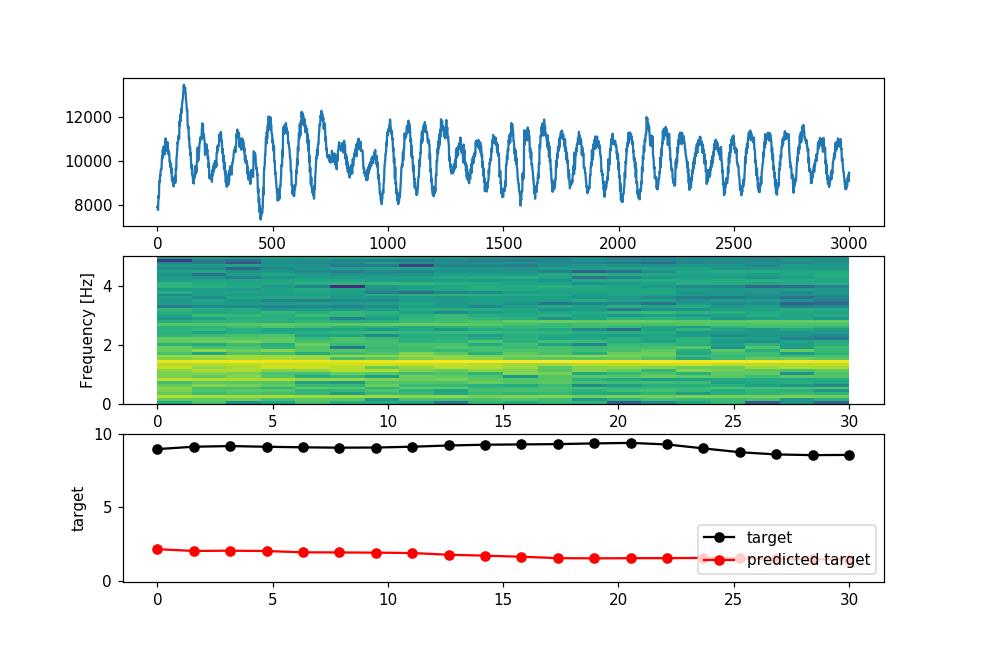

In [31]:
# Plot random sample
ichannel=0
nsample=Xs_plot.shape[0]
idx=np.random.randint(0,nsample)

# select from subset of samples containing positive labels
# select data where y has a positive hit
idx_stick=np.where(np.max(Ys_plot,axis=1)>3)[0]
# idx_stick=np.where((np.max(np.abs(Ys_plot-Y_predict),axis=1)<1) & (np.max(Ys_plot,axis=1)>2))[0]

# idx_stick=np.where(np.max(np.round(Y_predict),axis=1)>0)[0]

# idx=np.random.randint(0,nsample)
idx=np.random.choice(idx_stick)

Xs_sample=Xs_plot[idx,:,:,ichannel]
Xt_sample=Xt_plot[idx,:,ichannel]

Ys_sample=Ys_plot[idx]
Yt_sample=Yt_plot[idx]


# plt.figure(dpi=150)
plt.figure(figsize=[9,6])
ax1=plt.subplot(311)
plt.plot(Xt_sample)
# plt.plot(X_time[m,:,1])
# plt.plot(X_time[m,:,3])


# Y_b = Y_binary[idx]
vf=np.linspace(0,freqMax,nf)
vt=np.linspace(0,ntSample*dt,ntSpec)
vt2=np.linspace(0,ntSample*dt,Xt_sample.shape[0])


ax2=plt.subplot(312)
extents = vt[0], vt[-1],vf[0],vf[-1]

plt.imshow(10*np.log10(np.transpose(Xs_sample)),aspect='auto',origin='lower',extent=extents)
# plt.imshow(Xs_sample,aspect='auto',origin='lower',extent=extents)
# plt.plot([vt[0],vt[-1]],[freqLimit,freqLimit],'-r')

plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
# plt.clim(40,80)
plt.ylim(0,5)

ax3=plt.subplot(313,sharex=ax2)


# plt.plot(vt2,Yt_sample,label='lat accel')
# plt.plot(vt2,Yt_sample,'o',label='lat accel')
plt.ylabel('acceleration (g)')
# ax3b=ax3.twinx()
# plt.plot(vt,Y_b,'-r',label='binary target')
plt.plot(vt,Ys_sample,'-ko',label='target')
plt.plot(vt,Y_predict[idx].ravel(),'-ro',label='predicted target')
# plt.plot(vt,np.round(Y_predict[idx].ravel()+0.4),'-go',label='predicted target')
plt.ylabel('target')

# ax3b.legend(loc=3)
ax3.legend(loc=4)
plt.ylim(-0.1,10)
# plt.suptitle(trainingDict['inputChannel'][ichannel])
plt.show()






### Cross-plotting data vs prediction 

<IPython.core.display.Javascript object>


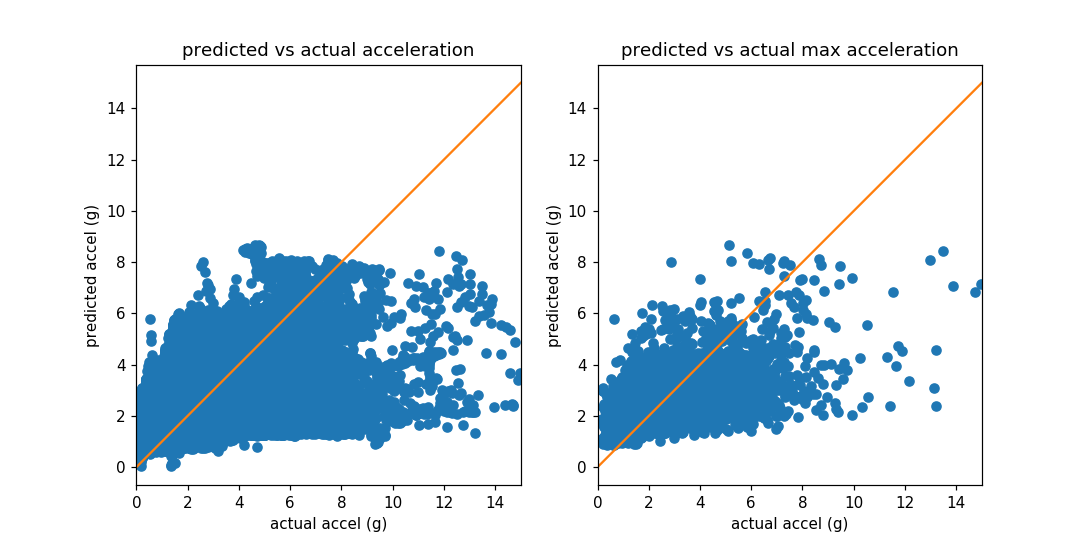

In [32]:
# Plotting statistics 
# accel0=10
plt.figure(figsize=[10,5])
ax1=plt.subplot(121)
plt.plot(Ys_plot.ravel(),Y_predict.ravel(),'o')
# plt.plot(accel0*Y_predict.ravel(),accel0*Ys_plot.ravel(),'o')

plt.plot([0,15],[0,15],'-')
plt.title('predicted vs actual acceleration')
plt.xlabel('actual accel (g)')
plt.ylabel('predicted accel (g)')
ax1.set_aspect('equal')
plt.xlim(0,15)
plt.ylim(0,15)
plt.show()

ax2=plt.subplot(122,sharex=ax1,sharey=ax1)
plt.plot(np.max(Ys_plot,axis=1),np.max(Y_predict,axis=1),'o')
plt.title('predicted vs actual max acceleration')
plt.xlabel('actual accel (g)')
plt.ylabel('predicted accel (g)')
ax2.set_aspect('equal')
plt.plot([0,15],[0,15],'-')
plt.xlim(0,15)
plt.ylim(0,15)
plt.show()

### Plot model prediction with Depth

In [22]:
np.mean((Ys_plot-Y_predict_test)**2)

1.4710350883496659

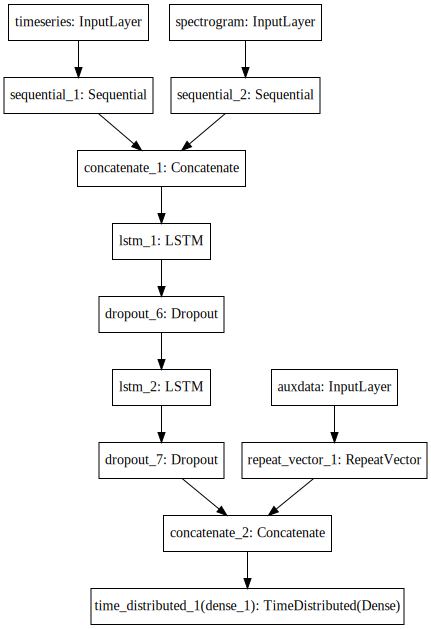

In [33]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

# plot_model(model, to_file='model.png')


SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [34]:
def r2Coeff(y_data,y_pred):
    ss_tot=np.sum((y_data-np.mean(y_data))**2)
    ss_res=np.sum((y_data-y_pred)**2)
    r2=1-ss_res/ss_tot
    return r2

In [35]:
# r2Coeff(Ys_train,Y_predict_train)
r2_train=r2Coeff(np.max(Ys_train,axis=1),np.max(Y_predict_train,axis=1))
r2_test=r2Coeff(np.max(Ys_test,axis=1),np.max(Y_predict_test,axis=1))

<IPython.core.display.Javascript object>


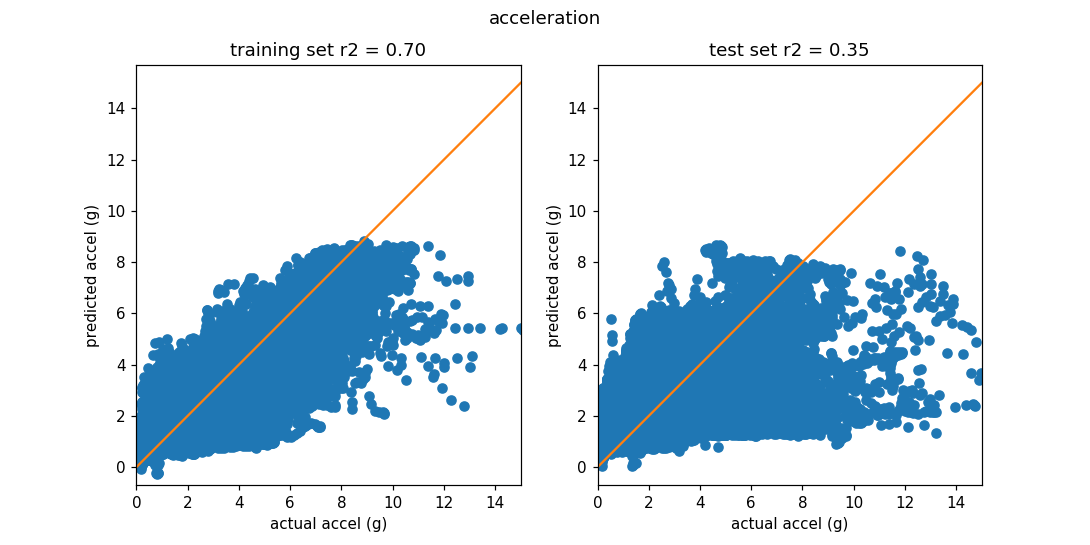

<IPython.core.display.Javascript object>


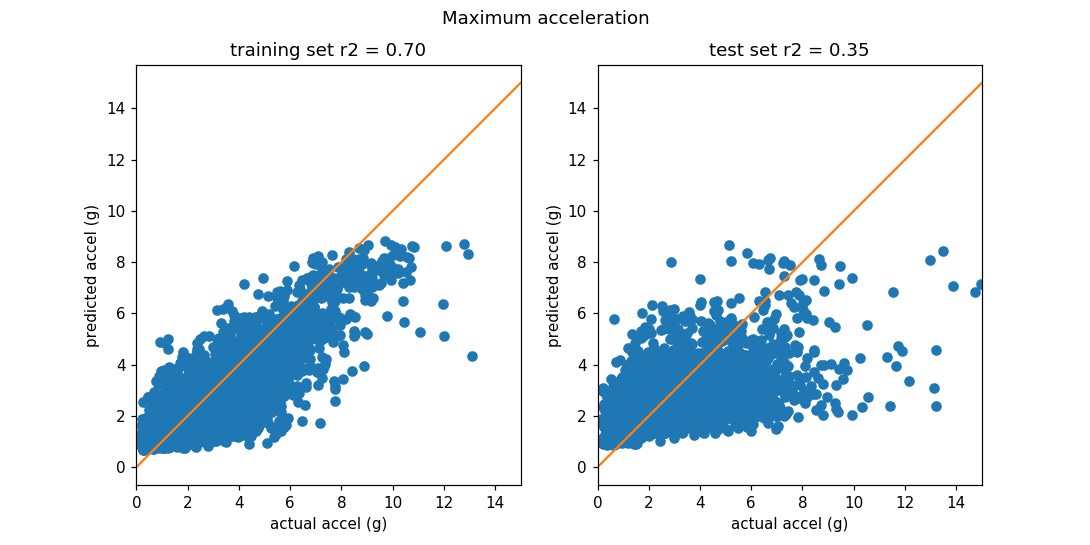

Text(0.5,0.98,'Maximum acceleration')

In [36]:
# Plotting statistics 
plt.figure(figsize=[10,5])
ax1=plt.subplot(121)
plt.plot(Ys_train.ravel(),Y_predict_train.ravel(),'o')
# plt.plot(accel0*Y_predict.ravel(),accel0*Ys_plot.ravel(),'o')

plt.plot([0,15],[0,15],'-')
plt.title('training set r2 = %2.2f'%r2_train)
plt.xlabel('actual accel (g)')
plt.ylabel('predicted accel (g)')
ax1.set_aspect('equal')
plt.xlim(0,15)
plt.ylim(0,15)
plt.show()

ax2=plt.subplot(122,sharex=ax1,sharey=ax1)
plt.plot(Ys_test.ravel(),Y_predict_test.ravel(),'o')
plt.title('test set r2 = %2.2f'%r2_test)
plt.xlabel('actual accel (g)')
plt.ylabel('predicted accel (g)')
ax2.set_aspect('equal')
plt.plot([0,15],[0,15],'-')
plt.xlim(0,15)
plt.ylim(0,15)
plt.show()
plt.suptitle('acceleration')

plt.figure(figsize=[10,5])
ax1=plt.subplot(121)
# plt.plot(accel0*Ys_train.ravel(),accel0*Y_predict_train.ravel(),'o')
plt.plot(np.max(Ys_train,axis=1),np.max(Y_predict_train,axis=1),'o')

plt.plot([0,15],[0,15],'-')
plt.title('training set r2 = %2.2f'%r2_train)
plt.xlabel('actual accel (g)')
plt.ylabel('predicted accel (g)')
ax1.set_aspect('equal')
plt.xlim(0,15)
plt.ylim(0,15)
plt.show()

ax2=plt.subplot(122,sharex=ax1,sharey=ax1)
plt.plot(np.max(Ys_test,axis=1),np.max(Y_predict_test,axis=1),'o')
plt.title('test set r2 = %2.2f'%r2_test)
plt.xlabel('actual accel (g)')
plt.ylabel('predicted accel (g)')
ax2.set_aspect('equal')
plt.plot([0,15],[0,15],'-')
plt.xlim(0,15)
plt.ylim(0,15)
plt.show()
plt.suptitle('Maximum acceleration')

### Plot with depth

<IPython.core.display.Javascript object>


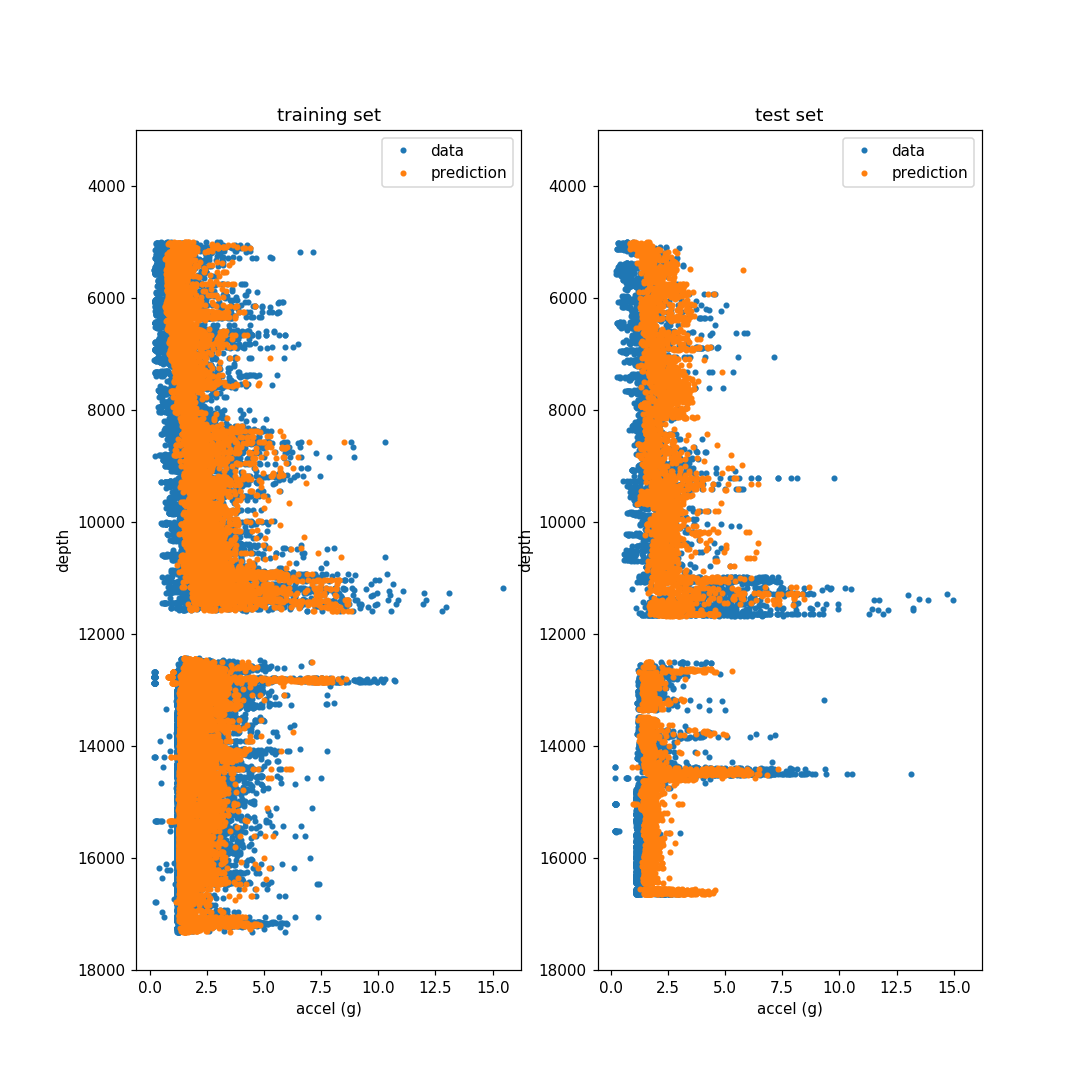

<IPython.core.display.Javascript object>


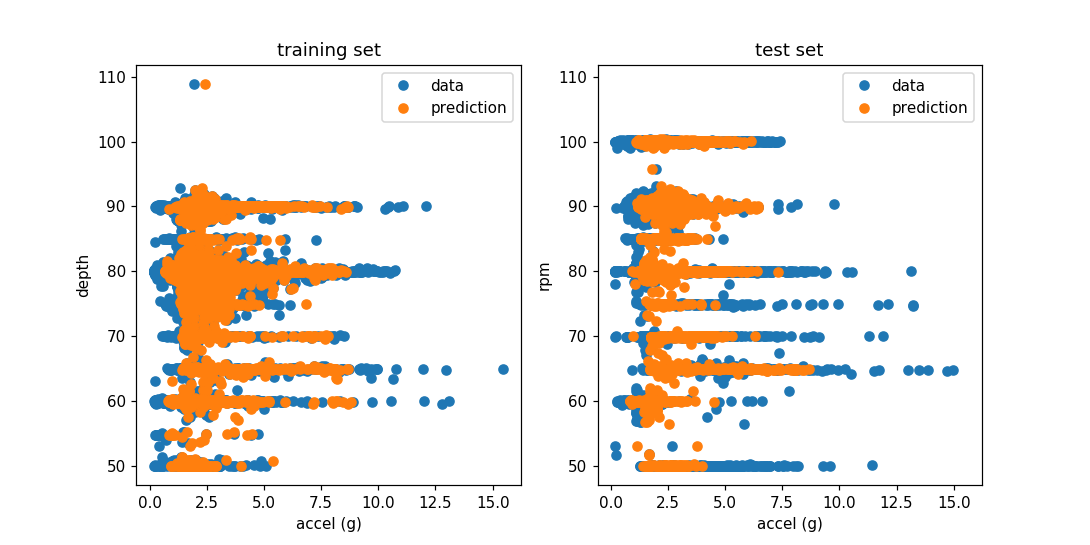

In [37]:
depth_train=auxDataDict_train['01_Global-Generic_Surface-BIT_DEPTH']
depth_test=auxDataDict_test['01_Global-Generic_Surface-BIT_DEPTH']

rpm_train=auxDataDict_train['01_Global-Generic_Surface-SRPM']
rpm_test=auxDataDict_test['01_Global-Generic_Surface-SRPM']
plt.figure(figsize=[10,10])
ax1=plt.subplot(121)
# plt.plot(np.max(accel0*Y_predict_test,axis=1),depth_test,'o',label='validation')
plt.plot(np.max(Ys_train,axis=1),depth_train*3.28,'.',label='data')
plt.plot(np.max(Y_predict_train,axis=1),depth_train*3.28,'.',label='prediction')
# plt.gca().invert_yaxis()
plt.title('training set')
plt.xlabel('accel (g)')
plt.ylabel('depth')
plt.xlim(0,15)
plt.ylim(18000,3000)
plt.show()
plt.legend()

ax2=plt.subplot(122,sharex=ax1,sharey=ax1)
plt.plot(np.max(Ys_test,axis=1),depth_test*3.28,'.',label='data')
plt.plot(np.max(Y_predict_test,axis=1),depth_test*3.28,'.',label='prediction')

plt.title('test set')
plt.xlabel('accel (g)')
plt.ylabel('depth')
# plt.xlim(0,15)
plt.ylim(18000,3000)
plt.legend()
plt.show()

plt.figure(figsize=[10,5])
ax1=plt.subplot(121)
# plt.plot(np.max(accel0*Y_predict_test,axis=1),depth_test,'o',label='validation')
plt.plot(np.max(Ys_train,axis=1),rpm_train,'o',label='data')
plt.plot(np.max(Y_predict_train,axis=1),rpm_train,'o',label='prediction')

plt.title('training set')
plt.xlabel('accel (g)')
plt.ylabel('depth')
plt.xlim(0,15)
# plt.ylim(0,15)
plt.show()
plt.legend()

ax2=plt.subplot(122,sharex=ax1,sharey=ax1)
plt.plot(np.max(Ys_test,axis=1),rpm_test,'o',label='data')
plt.plot(np.max(Y_predict_test,axis=1),rpm_test,'o',label='prediction')

plt.title('test set')
plt.xlabel('accel (g)')
plt.ylabel('rpm')
# plt.xlim(0,15)
# plt.ylim(0,15)
plt.legend()
plt.show()

### Save model

In [39]:
imodel=np.argmin([score[0] for score in scoreList])
#imodel=np.argmax([score[2] for score in scoreList])

model=modelList[imodel]
param=ParamList[imodel]
# model_name = 'regression_8channel_30s_50Hz_separateData.h5'
model_name = 'regression/models/regression_8channel_30s_meta_norm'+str(freqMax)+'Hz_separateData_nlstm='+str(param[0])+'_dropout='+str(param[1])
# model.save(model_name)

# Save as Json and weights
# Save model
json_name=model_name+'.json'
model_json = model.to_json()
with open(json_name, "w") as json_file:
    json_file.write(model_json)
model.save_weights(model_name+'.h5')

### validate against different data

In [51]:


testFileList=['/home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_30s_8channel_RR31_noNorm.p',
#               '/home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_30s_8channel_RR31.p',
#               '/home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_60s_6channel_RR32.p',
#               '/home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_60s_6channel_RR34.p',
#               '/home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_60s_6channel_RR35.p'
             ]
# parameters to generate spectrogram
nfft=1024
nfftOverlap=nfft*0.9

# sampling rate of data
fs=100
dt=1/fs

# maximum frequency to look at 
freqMax=20

batchSize=32
conditionList=[['01_Global-Generic_Surface-copRigState',0,100],['01_Global-Generic_Surface-SRPM',0,50],
#                ['01_Global-Generic_Surface-BIT_DEPTH', 8500/3.28,12500/3.28]
              ]
fg = deep_util.FeatureGenerator()
fg.setParam(nfft=nfft,nfftOverlap=nfftOverlap,freqMax=freqMax,batchSize=batchSize,conditionList=conditionList)

X_test,Y_test,auxDataDict_test=fg.GenerateFeatures(testFileList,conditionList,ytype='mean',cutToBatch=True)

Reading file /home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_30s_8channel_RR31_noNorm.p
reading 26738.000000 samples
Size of merged data X is: 
number of samples
26738
Shape of X (nsample,nt,nchannel):
(26738, 3000, 8)
 0 percent finished
10 percent finished
20 percent finished
30 percent finished
40 percent finished
50 percent finished
60 percent finished
70 percent finished
80 percent finished
90 percent finished


In [52]:
# Normalize
Xt_test,Xs_test=X_test
Yt_test,Ys_test=Y_test
Xt_test_norm=scaler_time.transform(Xt_test)
Xs_test_norm=scaler_spec.transform(Xs_test)
# Xnorm_train = [Xt_train_norm,Xs_train_norm]
Xnorm_test = [Xt_test_norm,Xs_test_norm]

nsample_train=Xt_train.shape[0]
nsample_test=Xt_test.shape[0]

# meta data
metaData_test=np.zeros((nsample_test,3))
metaData_test[:,0] = auxDataDict_test['01_Global-Generic_Surface-SRPM']
metaData_test[:,1] = auxDataDict_test['01_Global-Generic_Surface-SWOB']
metaData_test[:,2] = auxDataDict_test['01_Global-Generic_Surface-copROP']
metaData_test_norm = scaler.transform(metaData_test)

In [53]:
Feature_test=[Xnorm_test[0],Xnorm_test[1],metaData_test_norm]
Target_test=transform(Y_test[1])
Y_predict_test=inverseTransform(model.predict(Feature_test,verbose=1))

20128/20128 [==============================] - 24s 1ms/step


<IPython.core.display.Javascript object>


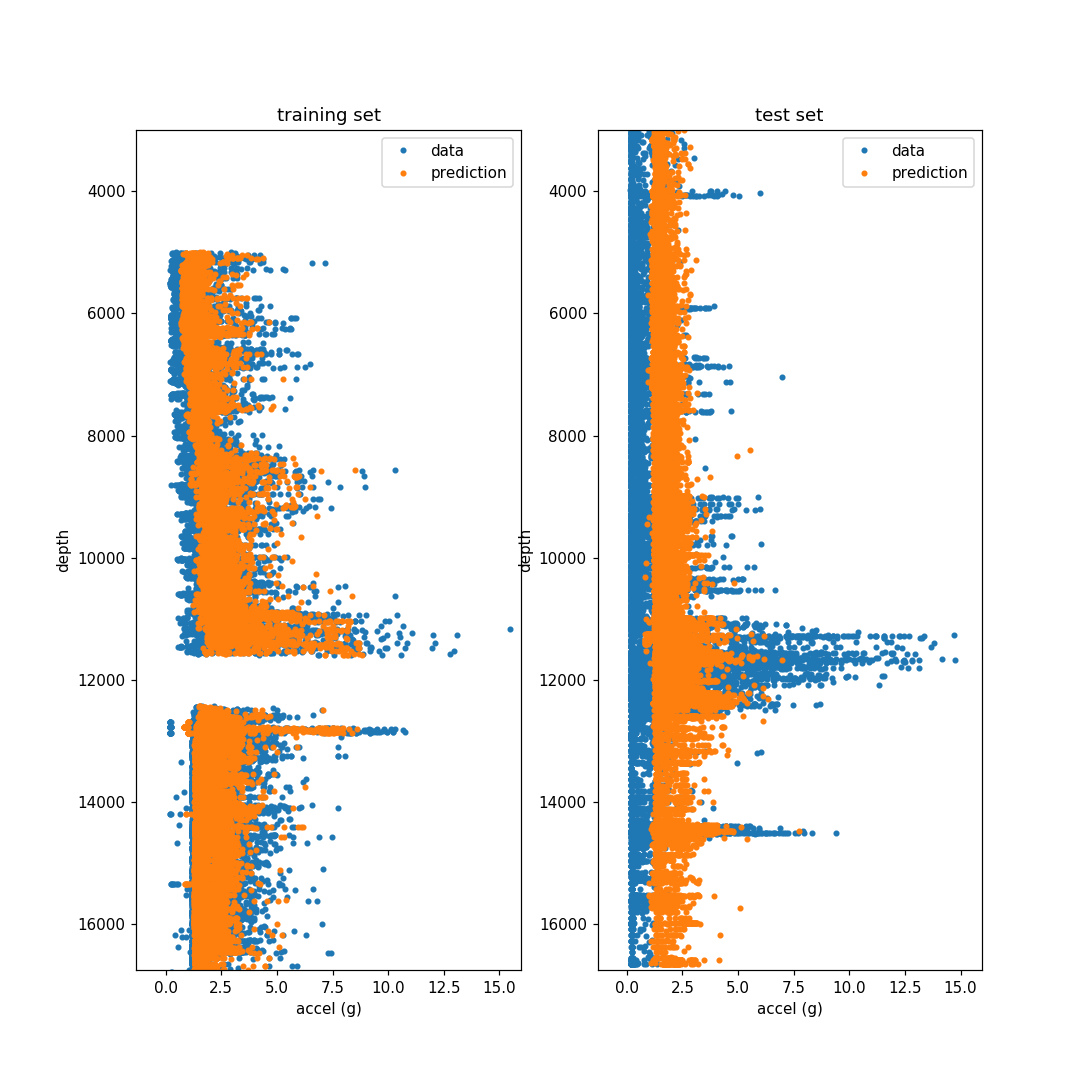

<IPython.core.display.Javascript object>


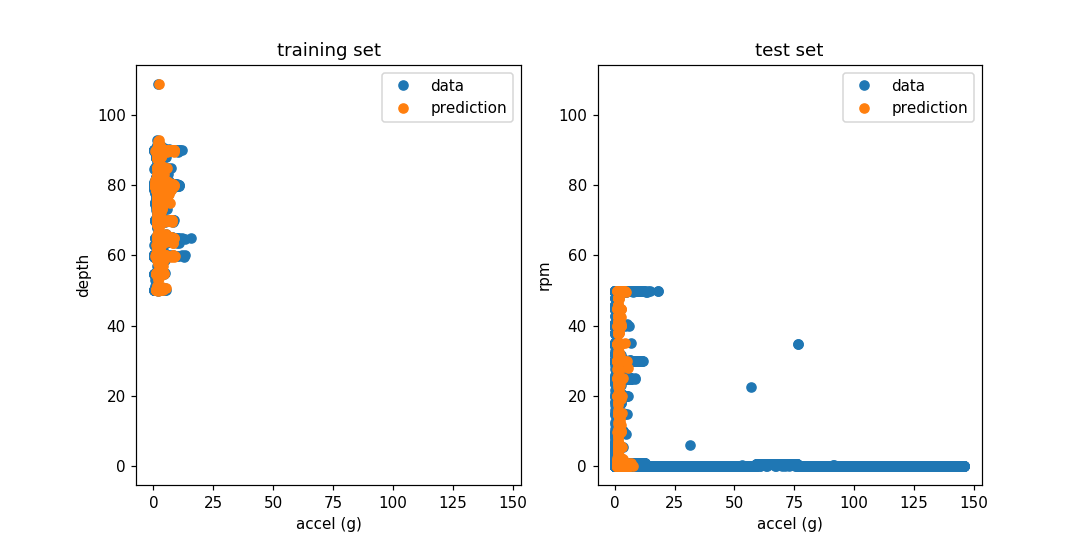

In [54]:
depth_train=auxDataDict_train['01_Global-Generic_Surface-BIT_DEPTH']
depth_test=auxDataDict_test['01_Global-Generic_Surface-BIT_DEPTH']

rpm_train=auxDataDict_train['01_Global-Generic_Surface-SRPM']
rpm_test=auxDataDict_test['01_Global-Generic_Surface-SRPM']
plt.figure(figsize=[10,10])
ax1=plt.subplot(121)
# plt.plot(np.max(accel0*Y_predict_test,axis=1),depth_test,'o',label='validation')
plt.plot(np.max(Ys_train,axis=1),depth_train*3.28,'.',label='data')
plt.plot(np.max(Y_predict_train,axis=1),depth_train*3.28,'.',label='prediction')
# plt.gca().invert_yaxis()
plt.title('training set')
plt.xlabel('accel (g)')
plt.ylabel('depth')
plt.xlim(0,15)
plt.ylim(18000,3000)
plt.show()
plt.legend()

ax2=plt.subplot(122,sharex=ax1,sharey=ax1)
plt.plot(np.max(Ys_test,axis=1),depth_test*3.28,'.',label='data')
plt.plot(np.max(Y_predict_test,axis=1),depth_test*3.28,'.',label='prediction')

plt.title('test set')
plt.xlabel('accel (g)')
plt.ylabel('depth')
# plt.xlim(0,15)
plt.ylim(18000,3000)
plt.legend()
plt.show()

plt.figure(figsize=[10,5])
ax1=plt.subplot(121)
# plt.plot(np.max(accel0*Y_predict_test,axis=1),depth_test,'o',label='validation')
plt.plot(np.max(Ys_train,axis=1),rpm_train,'o',label='data')
plt.plot(np.max(Y_predict_train,axis=1),rpm_train,'o',label='prediction')

plt.title('training set')
plt.xlabel('accel (g)')
plt.ylabel('depth')
plt.xlim(0,15)
# plt.ylim(0,15)
plt.show()
plt.legend()

ax2=plt.subplot(122,sharex=ax1,sharey=ax1)
plt.plot(np.max(Ys_test,axis=1),rpm_test,'o',label='data')
plt.plot(np.max(Y_predict_test,axis=1),rpm_test,'o',label='prediction')

plt.title('test set')
plt.xlabel('accel (g)')
plt.ylabel('rpm')
# plt.xlim(0,15)
# plt.ylim(0,15)
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


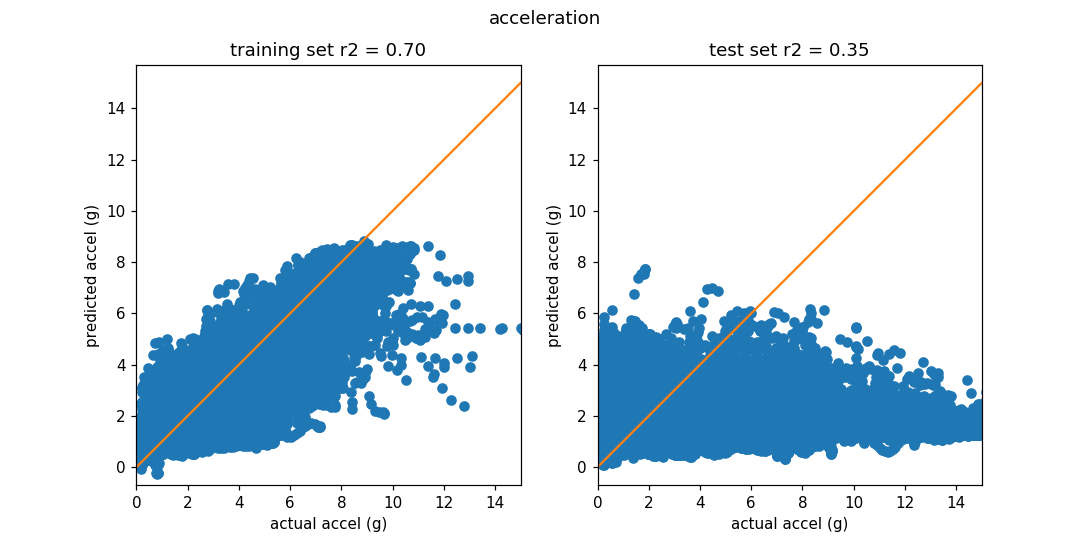

<IPython.core.display.Javascript object>


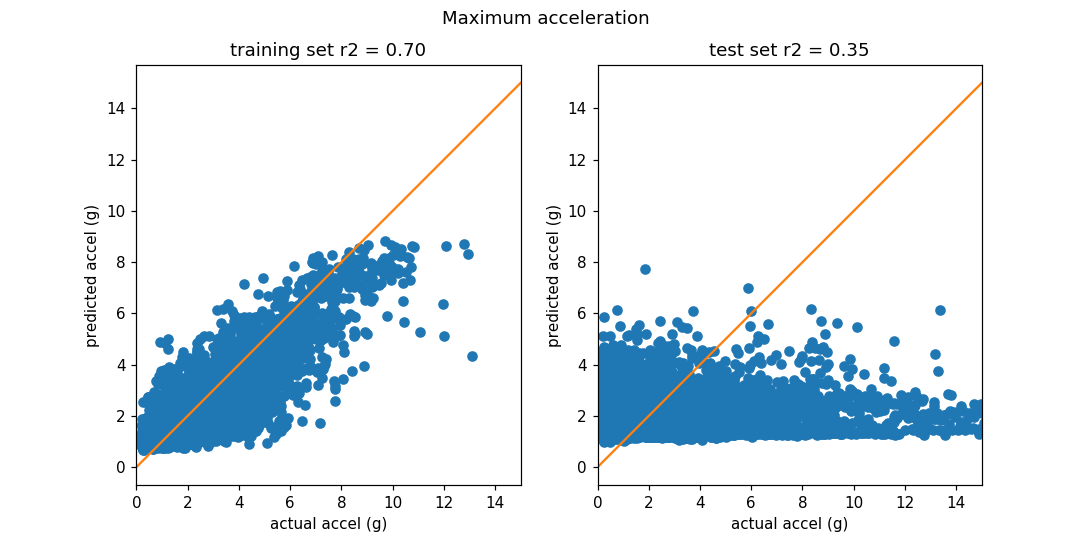

Text(0.5,0.98,'Maximum acceleration')

In [55]:
# Plotting statistics 
plt.figure(figsize=[10,5])
ax1=plt.subplot(121)
plt.plot(Ys_train.ravel(),Y_predict_train.ravel(),'o')
# plt.plot(accel0*Y_predict.ravel(),accel0*Ys_plot.ravel(),'o')

plt.plot([0,15],[0,15],'-')
plt.title('training set r2 = %2.2f'%r2_train)
plt.xlabel('actual accel (g)')
plt.ylabel('predicted accel (g)')
ax1.set_aspect('equal')
plt.xlim(0,15)
plt.ylim(0,15)
plt.show()

ax2=plt.subplot(122,sharex=ax1,sharey=ax1)
plt.plot(Ys_test.ravel(),Y_predict_test.ravel(),'o')
plt.title('test set r2 = %2.2f'%r2_test)
plt.xlabel('actual accel (g)')
plt.ylabel('predicted accel (g)')
ax2.set_aspect('equal')
plt.plot([0,15],[0,15],'-')
plt.xlim(0,15)
plt.ylim(0,15)
plt.show()
plt.suptitle('acceleration')

plt.figure(figsize=[10,5])
ax1=plt.subplot(121)
# plt.plot(accel0*Ys_train.ravel(),accel0*Y_predict_train.ravel(),'o')
plt.plot(np.max(Ys_train,axis=1),np.max(Y_predict_train,axis=1),'o')

plt.plot([0,15],[0,15],'-')
plt.title('training set r2 = %2.2f'%r2_train)
plt.xlabel('actual accel (g)')
plt.ylabel('predicted accel (g)')
ax1.set_aspect('equal')
plt.xlim(0,15)
plt.ylim(0,15)
plt.show()

ax2=plt.subplot(122,sharex=ax1,sharey=ax1)
plt.plot(np.max(Ys_test,axis=1),np.max(Y_predict_test,axis=1),'o')
plt.title('test set r2 = %2.2f'%r2_test)
plt.xlabel('actual accel (g)')
plt.ylabel('predicted accel (g)')
ax2.set_aspect('equal')
plt.plot([0,15],[0,15],'-')
plt.xlim(0,15)
plt.ylim(0,15)
plt.show()
plt.suptitle('Maximum acceleration')